<a href="https://colab.research.google.com/github/shizuo-kaji/AffineLib/blob/master/codes/vfield_koopman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Function Definitions

In [1]:
# utility functions
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.axes_grid1
from pynhhd import nHHD
from scipy import interpolate,sparse
import matplotlib.colors as colors


# Helmholtz decomposition by convolving the Green function for the free boundary
def decomp(v):
  kx = np.fft.fftfreq(v.shape[0]).reshape(-1,1)
  ky = np.fft.fftfreq(v.shape[1])
  k2 = kx**2 + ky**2
  k2[0,0] = 1.
  dk = (np.fft.fftn(v[:,:,0]) * kx +  np.fft.fftn(v[:,:,1]) * ky) / k2
  r = np.stack((np.fft.ifftn(dk * kx).real, np.fft.ifftn(dk * ky).real), axis=-1) # div free
  d = np.stack((v[:,:,0] - r[:,:,0], v[:,:,1] - r[:,:,1]), axis=-1 ) # rot free
  return(r,d)

# gradient
def grad(f):
  ddy, ddx = np.gradient(f, dx[0], dx[1])
  return(np.stack((ddx, ddy), axis = -1))

# rotated gradient
def rot_grad(f):
  ddy, ddx = np.gradient(f, dx[0], dx[1])
  ddy *= -1.0
  return(np.stack((ddy, ddx), axis=-1))

# divergence and curl
def divcurl(vfield):
  dudy, dudx = np.gradient(vfield[:,:,0], dx[0], dx[1])
  dvdy, dvdx = np.gradient(vfield[:,:,1], dx[0], dx[1])
  np.add(dudx, dvdy, dudx)
  np.subtract(dvdx, dudy, dvdx)
  return (dudx, dvdx)

# quick-dirty integrator of a 2d vector field
def integrate(v): 
  SdZx = np.cumsum(v[:,:,0], axis=1)*dx[1]
  SdZy = np.cumsum(v[:,:,1], axis=0)*dx[0]
  N,M = SdZx.shape
  Zhat = np.zeros((N,M))
  for i in range(N):
      for j in range(M):
          Zhat[i,j] = SdZx[0,M//2] +SdZy[i,M//2]+ SdZx[i,j]-SdZx[i,M//2]
  return(Zhat)

# integration after interpolation of a 2d vector field
def integrate2(v, fac=2): 
  M, N = v.shape[:2]
  xl = np.linspace(0, 1, N)
  yl = np.linspace(0, 1, M)
  X, Y = np.meshgrid(xl, yl)
  r = np.stack([X.ravel(), Y.ravel()]).T
  Sx = interpolate.CloughTocher2DInterpolator(r, v[:,:,0].ravel())
  Sy = interpolate.CloughTocher2DInterpolator(r, v[:,:,1].ravel())
  # slow
#  Sx = interpolate.Rbf(r[:,0], r[:,1], v[:,:,0].ravel(), function='thin_plate')
#  Sy = interpolate.Rbf(r[:,0], r[:,1], v[:,:,1].ravel(), function='thin_plate')
  xli = np.linspace(0, 1, fac*N)
  yli = np.linspace(0, 1, fac*M)
  Xi, Yi = np.meshgrid(xli, yli)
  ri = np.stack([Xi.ravel(), Yi.ravel()]).T
  dZdxi = Sx(ri).reshape(Xi.shape)
  dZdyi = Sy(ri).reshape(Xi.shape)
#  dZdxi = Sx(ri[:,0],ri[:,1]).reshape(Xi.shape)
#  dZdyi = Sy(ri[:,0],ri[:,1]).reshape(Xi.shape)
#  print(np.abs(v[:,:,0]-dZdxi[::fac,::fac]).mean())
  SdZxi = np.nancumsum(dZdxi, axis=1)*dx[1]/fac
  SdZyi = np.nancumsum(dZdyi, axis=0)*dx[0]/fac
  Zhati = np.zeros(SdZxi.shape)
  N, M = Zhati.shape
  for i in range(N):
      for j in range(M):
          Zhati[i,j] = SdZxi[0,M//2] +SdZyi[i,M//2]+ SdZxi[i,j]-SdZxi[i,M//2]
#          Zhati[i,j] = SdZyi[i,0]-SdZyi[0,0]+SdZxi[i,j]-SdZxi[i,0]
  return(Zhati[::fac,::fac])

# infinitesimal Koopman generator
def koopman_L(vx,vy,dx=(1,1),augment=0):
  ny,nx = vx.shape
  ## grad_x * vx
  Gx = sparse.dok_matrix((nx*ny+augment,nx*ny))
  if augment > 0:
    Gx[nx*ny,0] = 1 ## enforce phi[0] = 1 (killing ambiguity by a scalar multiple)
  for y in range(ny):
    Gx[y*nx, y*nx+1] = vx[y,0]/dx[1] # coeff of f(1,y) in df(0,y)
    Gx[y*nx, y*nx] = -vx[y,0]/dx[1] # (0,y) -> (0,y)
    Gx[y*nx+nx-1, y*nx+nx-1] = vx[y,nx-1]/dx[1] # (nx-1,y) -> (nx-1,y)
    Gx[y*nx+nx-1, y*nx+nx-2] = -vx[y,nx-1]/dx[1] #(nx-2,y) -> (nx-1,y)
    for x in range(1,nx-1):
      Gx[y*nx+x, y*nx+x+1] = 0.5*vx[y,x]/dx[1]
      Gx[y*nx+x, y*nx+x-1] = -0.5*vx[y,x]/dx[1]

  ## grad_y * vy
  Gy = sparse.dok_matrix((nx*ny+augment,nx*ny))
  for x in range(nx):
    Gy[x, 1*nx+x] = vy[0,x]/dx[0]
    Gy[x, x] = -vy[0,x]/dx[0]
    Gy[(ny-1)*nx+x, (ny-1)*nx+x] = vy[ny-1,x]/dx[0]
    Gy[(ny-1)*nx+x, (ny-2)*nx+x] = -vy[ny-1,x]/dx[0]
    for y in range(1,ny-1):
      Gy[y*nx+x, (y+1)*nx+x] = 0.5*vy[y,x]/dx[0]
      Gy[y*nx+x, (y-1)*nx+x] = -0.5*vy[y,x]/dx[0]


  #return(Gx.todense(), Gy.todense())
  return(Gx.tocsr() + Gy.tocsr())
  
def koopman_Lab(vx,vy,dx=(1,1),_a=10,_b=3,augment=0):
    # Scharr filter (a,b)=(10,3)
    # Sobel filter  (a,b)=(2,1)
  ny,nx = vx.shape
  a,b = _a,_b
  c = a+2*b
  a /= c
  b /= c
  a2 = a/(a+b)
  b2 = b/(a+b)
  ## grad_x * vx
  Gx = sparse.dok_matrix(((nx)*(ny)+augment,(nx)*(ny)))
  if augment > 0:
    Gx[(nx)*(ny),0] = 1 ## enforce phi[0] = 1 (killing ambiguity by a scalar multiple)

  ## (y,x)=(0,0)
  Gx[0, 1] = 2*a2*vx[0,0]/dx[1]
  Gx[0, 0] = -2*a2*vx[0,0]/dx[1]
  Gx[0, nx+1] = 2*b2*vx[0,0]/dx[1]
  Gx[0, nx] = -2*b2*vx[0,0]/dx[1]
  ## (y,x)=(0,nx-1)
  Gx[nx-1, nx-1] = 2*a2*vx[0,nx-1]/dx[1]
  Gx[nx-1, nx-2] = -2*a2*vx[0,nx-1]/dx[1]
  Gx[nx-1, 2*nx-1] = 2*b2*vx[0,nx-1]/dx[1]
  Gx[nx-1, 2*nx-2] = -2*b2*vx[0,nx-1]/dx[1]
  ## (y,x)=(ny-1,0)
  Gx[(ny-1)*nx, (ny-1)*nx+1] = 2*a2*vx[ny-1,0]/dx[1]
  Gx[(ny-1)*nx, (ny-1)*nx] = -2*a2*vx[ny-1,0]/dx[1]
  Gx[(ny-1)*nx, (ny-2)*nx+1] = 2*b2*vx[ny-1,0]/dx[1]
  Gx[(ny-1)*nx, (ny-2)*nx] = -2*b2*vx[ny-1,0]/dx[1]
  ## (y,x)=(ny-1,nx-1)
  Gx[ny*nx-1, ny*nx-1] = 2*a2*vx[ny-1,nx-1]/dx[1]
  Gx[ny*nx-1, ny*nx-2] = -2*a2*vx[ny-1,nx-1]/dx[1]
  Gx[ny*nx-1, (ny-1)*nx-1] = 2*b2*vx[ny-1,nx-1]/dx[1]
  Gx[ny*nx-1, (ny-1)*nx-2] = -2*b2*vx[ny-1,nx-1]/dx[1]
  ## (0,x)
  for x in range(1,nx-1):
      Gx[x, x+1] = a2*vx[0,x]/dx[1]
      Gx[x, x-1] = -a2*vx[0,x]/dx[1]
      Gx[x, nx+x+1] = b2*vx[0,x]/dx[1]
      Gx[x, nx+x-1] = -b2*vx[0,x]/dx[1]
  ## (ny-1,x)
  for x in range(1,nx-1):
      Gx[(ny-1)*nx+x, (ny-1)*nx+x+1] = a2*vx[ny-1,x]/dx[1]
      Gx[(ny-1)*nx+x, (ny-1)*nx+x-1] = -a2*vx[ny-1,x]/dx[1]
      Gx[(ny-1)*nx+x, (ny-2)*nx+x+1] = b2*vx[ny-1,x]/dx[1]
      Gx[(ny-1)*nx+x, (ny-2)*nx+x-1] = -b2*vx[ny-1,x]/dx[1]
  ## (y,0)
  for y in range(1,ny-1):
      Gx[y*nx, y*nx+1] = 2*a*vx[y,0]/dx[1]
      Gx[y*nx, y*nx] = -2*a*vx[y,0]/dx[1]
      Gx[y*nx, (y-1)*nx+1] = 2*b*vx[y,0]/dx[1]
      Gx[y*nx, (y-1)*nx] = -2*b*vx[y,0]/dx[1]
      Gx[y*nx, (y+1)*nx+1] = 2*b*vx[y,0]/dx[1]
      Gx[y*nx, (y+1)*nx] = -2*b*vx[y,0]/dx[1]
  ## (y,nx-1)
  for y in range(1,ny-1):
      Gx[y*nx+nx-1, y*nx+nx-1] = 2*a*vx[y,nx-1]/dx[1]
      Gx[y*nx+nx-1, y*nx+nx-2] = -2*a*vx[y,nx-1]/dx[1]
      Gx[y*nx+nx-1, (y-1)*nx+nx-1] = 2*b*vx[y,nx-1]/dx[1]
      Gx[y*nx+nx-1, (y-1)*nx+nx-2] = -2*b*vx[y,nx-1]/dx[1]
      Gx[y*nx+nx-1, (y+1)*nx+nx-1] = 2*b*vx[y,nx-1]/dx[1]
      Gx[y*nx+nx-1, (y+1)*nx+nx-2] = -2*b*vx[y,nx-1]/dx[1]
  for y in range(1,ny-1):
    for x in range(1,nx-1):
      Gx[y*nx+x, y*nx+x+1] = a*vx[y,x]/dx[1]
      Gx[y*nx+x, y*nx+x-1] = -a*vx[y,x]/dx[1]
      Gx[y*nx+x, (y-1)*nx+x+1] = b*vx[y,x]/dx[1]
      Gx[y*nx+x, (y+1)*nx+x+1] = b*vx[y,x]/dx[1]
      Gx[y*nx+x, (y-1)*nx+x-1] = -b*vx[y,x]/dx[1]
      Gx[y*nx+x, (y+1)*nx+x-1] = -b*vx[y,x]/dx[1]

  ## grad_y * vy
  Gy = sparse.dok_matrix(((nx)*(ny)+augment,(nx)*(ny)))
  ## (y,x)=(0,0)
  Gy[0, nx] = 2*a2*vy[0,0]/dx[0]
  Gy[0, 0] = -2*a2*vy[0,0]/dx[0]
  Gy[0, nx+1] = 2*b2*vy[0,0]/dx[0]
  Gy[0, 1] = -2*b2*vy[0,0]/dx[0]
  ## (y,x)=(ny-1,0)
  Gy[(ny-1)*nx, (ny-1)*nx] = 2*a2*vy[ny-1,0]/dx[0]
  Gy[(ny-1)*nx, (ny-2)*nx] = -2*a2*vy[ny-1,0]/dx[0]
  Gy[(ny-1)*nx, (ny-1)*nx+1] = 2*b2*vy[ny-1,0]/dx[0]
  Gy[(ny-1)*nx, (ny-2)*nx+1] = -2*b2*vy[ny-1,0]/dx[0]
  ## (y,x)=(0,nx-1)
  Gy[nx-1, nx-1] = -2*a2*vy[0,nx-1]/dx[0]
  Gy[nx-1, 2*nx-1] = 2*a2*vy[0,nx-1]/dx[0]
  Gy[nx-1, nx-2] = -2*b2*vy[0,nx-1]/dx[0]
  Gy[nx-1, 2*nx-2] = 2*b2*vy[0,nx-1]/dx[0]
  ## (y,x)=(ny-1,nx-1)
  Gy[ny*nx-1, ny*nx-1] = 2*a2*vy[ny-1,nx-1]/dx[0]
  Gy[ny*nx-1, (ny-1)*nx-1] = -2*a2*vy[ny-1,nx-1]/dx[0]
  Gy[ny*nx-1, ny*nx-2] = 2*b2*vy[ny-1,nx-1]/dx[0]
  Gy[ny*nx-1, (ny-1)*nx-2] = -2*b2*vy[ny-1,nx-1]/dx[0]
  ## (y,x)=(y,0)
  for y in range(1,ny-1):
      Gy[y*nx, (y+1)*nx] = a2*vy[y,0]/dx[0]
      Gy[y*nx, (y-1)*nx] = -a2*vy[y,0]/dx[0]
      Gy[y*nx, (y+1)*nx+1] = b2*vy[y,0]/dx[0]
      Gy[y*nx, (y-1)*nx+1] = -b2*vy[y,0]/dx[0]
  ## (y,x)=(y,nx-1)
  for y in range(1,ny-1):
      Gy[y*nx+nx-1, (y+1)*nx+nx-1] = a2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y-1)*nx+nx-1] = -a2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y+1)*nx+nx-2] = b2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y-1)*nx+nx-2] = -b2*vy[y,nx-1]/dx[0]
  ## (0,x)
  for x in range(1,nx-1):
      Gy[x, nx+x] = 2*a*vy[0,x]/dx[0]
      Gy[x, x] = -2*a*vy[0,x]/dx[0]
      Gy[x, nx+x+1] = 2*b*vy[0,x]/dx[0]
      Gy[x, x+1] = -2*b*vy[0,x]/dx[0]
      Gy[x, nx+x-1] = 2*b*vy[0,x]/dx[0]
      Gy[x, x-1] = -2*b*vy[0,x]/dx[0]
  ## (ny-1,x)
  for x in range(1,nx-1):
      Gy[(ny-1)*nx+x, (ny-1)*nx+x] = 2*a*vy[ny-1,x]/dx[0]
      Gy[(ny-1)*nx+x, (ny-2)*nx+x] = -2*a*vy[ny-1,x]/dx[0]
      Gy[(ny-1)*nx+x, (ny-1)*nx+x+1] = 2*b*vy[ny-1,x]/dx[0]
      Gy[(ny-1)*nx+x, (ny-2)*nx+x+1] = -2*b*vy[ny-1,x]/dx[0]
      Gy[(ny-1)*nx+x, (ny-1)*nx+x-1] = 2*b*vy[ny-1,x]/dx[0]
      Gy[(ny-1)*nx+x, (ny-2)*nx+x-1] = -2*b*vy[ny-1,x]/dx[0]
  for y in range(1,ny-1):
      Gy[y*nx+nx-1, (y+1)*nx+nx-1] = a2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y-1)*nx+nx-1] = -a2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y+1)*nx+nx-2] = b2*vy[y,nx-1]/dx[0]
      Gy[y*nx+nx-1, (y-1)*nx+nx-2] = -b2*vy[y,nx-1]/dx[0]
  for y in range(1,ny-1):
    for x in range(1,nx-1):
      Gy[y*nx+x, (y+1)*nx+x] = a*vy[y,x]/dx[0]
      Gy[y*nx+x, (y-1)*nx+x] = -a*vy[y,x]/dx[0]
      Gy[y*nx+x, (y+1)*nx+x+1] = b*vy[y,x]/dx[0]
      Gy[y*nx+x, (y-1)*nx+x+1] = -b*vy[y,x]/dx[0]
      Gy[y*nx+x, (y+1)*nx+x-1] = b*vy[y,x]/dx[0]
      Gy[y*nx+x, (y-1)*nx+x-1] = -b*vy[y,x]/dx[0]

  #return(Gx.todense(), Gy.todense())
  return(Gx.tocsr() + Gy.tocsr())

# plot function and contour
def plot_cont(f, ax, levels=3, title="", norm=None):
  im = ax.imshow(f[::-1,:], cmap="coolwarm", norm=norm)
  CS = ax.contour(np.arange(0,f.shape[1]), np.arange(0,f.shape[0]), f[::-1,:], levels=levels,colors='k')
  ax.set_title(title)
  divider = mpl_toolkits.axes_grid1.make_axes_locatable(ax)
  cax = divider.append_axes('right', '5%', pad='3%')
  cax = fig.colorbar(im, cax=cax)

def plot_slines(vx,vy, ax, title=""):
    mgn = np.sqrt(vx*vx+vy*vy)
    ax.streamplot(np.arange(0,vx.shape[1]), np.arange(0,vx.shape[0]), vx,vy, color=mgn, linewidth=2, cmap=plt.cm.autumn)
    ax.set_aspect(1)
    
#### The following visualisation functions are taken from naturalHHD
#Copyright (c) 2015, Harsh Bhatia (bhatia4@llnl.gov)
# ------------------------------------------------------------------------------

# draw streamlines on a regular grid
def draw_slines(X, Y, u, v, vrng=None):
    mgn = np.sqrt(u*u + v*v)
    if vrng is not None:
      plt.clim(vmin=vrng[0], vmax=vrng[1])
    strm = plt.streamplot(X, Y, u, v, color=mgn, linewidth=2, cmap=plt.cm.autumn)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    frame.axes.set_aspect('equal') 
    #plt.colorbar(strm.lines)

# draw streamlines on a triangulation
def draw_quivers(points, vfield, vrng, n=20):

    s = 350
    X = points[::n,0]
    Y = points[::n,1]
    u = vfield[::n,0]
    v = vfield[::n,1]

    mgn = np.linalg.norm(vfield, axis=1)
    strm = plt.quiver(X,Y,u,v,mgn,pivot='tail',cmap=plt.cm.autumn,scale=s,scale_units='width',width=0.005)
    plt.clim(vmin=vrng[0], vmax=vrng[1])

    #frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)

    #frame.axes.set_aspect('equal') #, 'datalim'))
    plt.colorbar()

# ------------------------------------------------------------------------------
def draw_scatter3D(positions, normals=None, color=None, alpha=1, ax=None):

    if ax == None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.set_aspect('equal', 'datalim')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    if color == None:
        color = 'r'

    ax.scatter(positions[:,0], positions[:,1], positions[:,2], c=color, marker='.', alpha=alpha)

    if (normals != None):
        ax.quiver( positions[:,0], positions[:,1], positions[:,2],
                   normals[:,0], normals[:,1], normals[:,2],
                   length=10,pivot='tail',color='cyan')
# ------------------------------------------------------------------------------



ModuleNotFoundError: ignored

# Koopman demo


In [ ]:
# vector field definition
# set up the grid for the domain
ny = 100  # resolution
nx = 100
M = 2.0  #  the domain will be the square [-M,M]^2
dx = (2.0*M/ny, 2.0*M/nx)
X, Y = np.meshgrid(np.linspace(-M,M,nx),np.linspace(-M,M,ny))

# Yokoyama #1
vx = (X-1)*X*(X+1.2)*(1+0.3*Y)
vy = -(Y-0.9)*Y*(Y+1.3)*(1+0.2*X)

# Yokoyama #2
# vx = np.cos(X)
# vy = np.sin(Y)

# 3.(ストロガッツの本の例題6.6.3)
# vx = - 2 \cos x - \cos y
# vy =  - 2 \cos y - \cos x

# 4. (ストロガッツの本の例題6.6.1)
#vx = Y - Y**3
#vy =  -X - Y**2

# 5. (ストロガッツの本の演習6.6.9)
# (双極子固定点)
# vx = 2xy
# vy = y^2 -x^2

# 6. (ストロガッツの本の演習6.6.10-11)
# (2つ目モンスター)
# vx = y+y^2
# vy = x/2 + y/5 - xy + 6y^2/5
# (オウム)(パラメータ違いの例)
# vx = y+y^2
# vy =  -x + y/5 - xy + 6y^2/5

# または，非圧縮の例に有効かも試しても良いかもしれません．
# 7.
# vx = x( 1 + 3 y^2)
# vy = −(y + y^3)


## Van der Pol oscillator
#mu=1.0
#vx = mu*(X-(X**3)/3-Y)
#vy = X/mu
#vx = Y
#vy = mu*(1-X**2)*Y-X

##
#vx = Y-X**3+mu*X
#vy = -X

## Duffing
# delta=0.5
# alpha=1
# beta=-1
# vx = Y
# vy  = -delta*Y-X*(beta+alpha*X**2)

##
#vx = 2*X
#vy = Y-X**2

## Henon
#vx = 1-1.4*(X**2)+Y
#vy = 0.3*X

## simple gradient flow
#gd = rot_grad(np.exp(-(X-0.5)**2-Y**2) - np.exp(-(X+0.5)**2-Y**2))
#vx = gd[:,:,0]
#vy = gd[:,:,1]


/home/skaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:256: UserWarning: No contour levels were found within the data range.


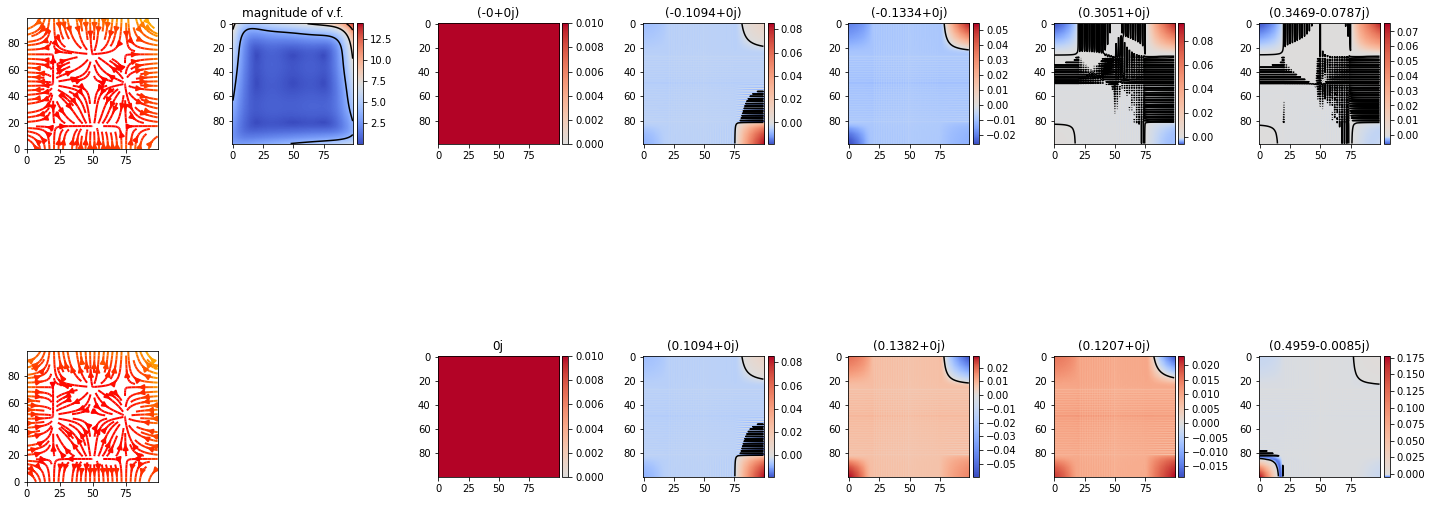

In [ ]:
# plot
k = 5 # number modes to plot
vmg = np.sqrt(vx**2+vy**2)
fig=plt.figure(figsize=(20,10))
plot_cont(vmg, fig.add_subplot(2,k+2,2), title="magnitude of v.f.")    

# set up the linear operator L
augment = 0
eps = 1e-2
idx = vmg.ravel()>eps
#print(idx.sum(), nx*ny)
for sig in [0,1]:
    ax = fig.add_subplot(2,k+2,1+sig*(k+2))
    plot_slines((-1)**sig*vx,(-1)**sig*vy,ax)
    G = koopman_Lab((-1)**sig*vx,(-1)**sig*vy,dx,_a=10,_b=3, augment=augment)
    G = G[np.ix_(idx,idx)]
    if augment > 0:
      b=np.zeros(G.shape[0])
      b[-1]=1 ## enforce phi[0] = 1 (killing ambiguity by a scalar multiple)
      phi = np.zeros(ny*nx)
      phi[idx] = sparse.linalg.spsolve(G.T.dot(G),G.T.dot(b))  
      phi = phi.reshape(ny,nx)
      divnorm = colors.TwoSlopeNorm(vcenter=0)
      plot_cont(phi, fig.add_subplot(2,k+2,3+sig*(k+2)), levels=[0], norm=divnorm)
    else:
      # compute k smallest eigen values and functions
      w, phis = sparse.linalg.eigs(G, k=k, which='SI', sigma=0.01, tol=1e-2, maxiter=5000)    # 'SI' for real eig vals
      for i in range(k):
        phi = np.zeros(ny*nx)
        phi[idx] = phis[:,i].real
        phi = phi.reshape(ny,nx)
        divnorm = colors.TwoSlopeNorm(vcenter=0)
        plot_cont(phi, fig.add_subplot(2,k+2,3+i+sig*(k+2)), title=str(np.round(w[i],4)), levels=[0], norm=divnorm)

fig.tight_layout()

